DataSet : https://networkrepository.com/fb-pages-food.php  
Explanation : https://www.analyticsvidhya.com/blog/2020/01/link-prediction-how-to-predict-your-future-connections-on-facebook/


In [1]:
import pandas as pd
import numpy as np
import random
import networkx as nx
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
# load nodes details
with open("fb-pages-food.nodes") as f:
    fb_nodes = f.read().splitlines() 

# load edges (or links)
with open("fb-pages-food.edges") as f:
    fb_links = f.read().splitlines() 

len(fb_nodes), len(fb_links)

(621, 2102)

In [3]:
# captture nodes in 2 separate lists
node_list_1 = []
node_list_2 = []

for i in tqdm(fb_links):
  node_list_1.append(i.split(',')[0])
  node_list_2.append(i.split(',')[1])

fb_df = pd.DataFrame({'node_1': node_list_1, 'node_2': node_list_2})

100%|██████████| 2102/2102 [00:00<00:00, 566280.88it/s]


In [4]:
fb_df.head()

,node_1,node_2
0,0,276
1,0,58
2,0,132
3,0,603
4,0,398


In [12]:
import dgl.data
import networkx as nx
import math
import itertools
import numpy as np

dataset = dgl.data.CoraGraphDataset()
g = dataset[0]
u, v = g.edges()
u_list = list(map(int, u))
v_list = list(map(int, v))


  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [13]:
fb_df = pd.DataFrame({'node_1': u_list, 'node_2': v_list})
fb_df.head()

,node_1,node_2
0,0,633
1,0,1862
2,0,2582
3,1,2
4,1,652


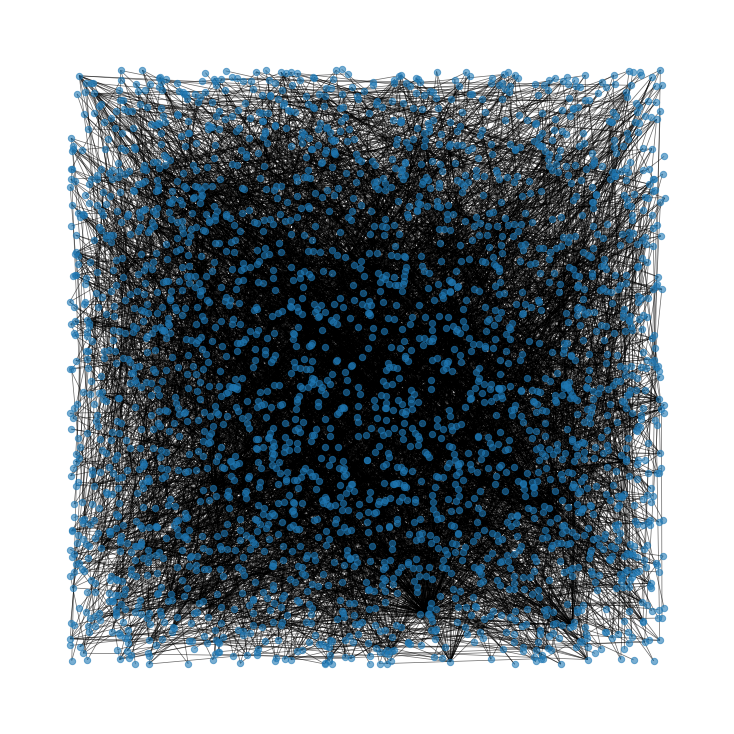

In [14]:
# create graph
G = nx.from_pandas_edgelist(fb_df, "node_1", "node_2", create_using=nx.Graph())

# plot graph
plt.figure(figsize=(10,10))

pos = nx.random_layout(G, seed=23)
nx.draw(G, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)

plt.show()

In [15]:
# combine all nodes in a list
node_list = node_list_1 + node_list_2

# remove duplicate items from the list
node_list = list(dict.fromkeys(node_list))

# build adjacency matrix
adj_G = nx.to_numpy_matrix(G, nodelist = node_list)

NetworkXError: Node 0 in nodelist is not in G

In [7]:
adj_G.shape

(620, 620)

In [8]:
# get unconnected node-pairs
all_unconnected_pairs = []

# traverse adjacency matrix
offset = 0
for i in tqdm(range(adj_G.shape[0])):
  for j in range(offset,adj_G.shape[1]):
    if i != j:
      if nx.shortest_path_length(G, str(i), str(j)) <=2:
        if adj_G[i,j] == 0:
          all_unconnected_pairs.append([node_list[i],node_list[j]])

  offset = offset + 1

100%|██████████| 620/620 [00:06<00:00, 97.64it/s] 


In [9]:
len(all_unconnected_pairs)

19018

In [10]:
node_1_unlinked = [i[0] for i in all_unconnected_pairs]
node_2_unlinked = [i[1] for i in all_unconnected_pairs]

data = pd.DataFrame({'node_1':node_1_unlinked, 
                     'node_2':node_2_unlinked})

# add target variable 'link'
data['link'] = 0

In [11]:
initial_node_count = len(G.nodes)

fb_df_temp = fb_df.copy()

# empty list to store removable links
omissible_links_index = []

for i in tqdm(fb_df.index.values):
  
  # remove a node pair and build a new graph
  G_temp = nx.from_pandas_edgelist(fb_df_temp.drop(index = i), "node_1", "node_2", create_using=nx.Graph())
  
  # check there is no spliting of graph and number of nodes is same
  if (nx.number_connected_components(G_temp) == 1) and (len(G_temp.nodes) == initial_node_count):
    omissible_links_index.append(i)
    fb_df_temp = fb_df_temp.drop(index = i)

100%|██████████| 2102/2102 [00:06<00:00, 337.31it/s]


In [12]:
len(omissible_links_index)

1483

In [13]:
# create dataframe of removable edges
fb_df_ghost = fb_df.loc[omissible_links_index]

# add the target variable 'link'
fb_df_ghost['link'] = 1

data = data.append(fb_df_ghost[['node_1', 'node_2', 'link']], ignore_index=True)

In [14]:
data['link'].value_counts()

0    19018
1     1483
Name: link, dtype: int64

In [15]:
# drop removable edges
fb_df_partial = fb_df.drop(index=fb_df_ghost.index.values)

# build graph
G_data = nx.from_pandas_edgelist(fb_df_partial, "node_1", "node_2", create_using=nx.Graph())

In [16]:
!pip install node2vec

In [17]:
from node2vec import Node2Vec

# Generate walks
node2vec = Node2Vec(G_data, dimensions=100, walk_length=16, num_walks=50)

# train node2vec model
n2w_model = node2vec.fit(window=7, min_count=1)

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:13<00:00,  3.63it/s]


TypeError: 'Word2Vec' object is not subscriptable :   
https://stackoverflow.com/questions/67922777/ploting-function-word2vec-error-word2vec-object-is-not-subscriptable  
model[str(i)]했더니 에러가나서 model.wv[str(i)] 했더니 됐다.

In [18]:
x = [(n2w_model.wv[str(i)]+n2w_model.wv[str(j)]) for i,j in zip(data['node_1'], data['node_2'])]

In [19]:
xtrain, xtest, ytrain, ytest = train_test_split(np.array(x), data['link'], 
                                                test_size = 0.3, 
                                                random_state = 35)

In [20]:
lr = LogisticRegression(class_weight="balanced")

lr.fit(xtrain, ytrain)

/home/kangjunekoo/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(class_weight='balanced')

In [21]:
predictions = lr.predict_proba(xtest)

In [22]:
roc_auc_score(ytest, predictions[:,1])

0.779938897248718

In [23]:
!pip install lightgbm

In [24]:
import lightgbm as lgbm

train_data = lgbm.Dataset(xtrain, ytrain)
test_data = lgbm.Dataset(xtest, ytest)

# define parameters
parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'num_threads' : 2,
    'seed' : 76
}

# train lightGBM model
model = lgbm.train(parameters,
                   train_data,
                   valid_sets=test_data,
                   num_boost_round=1000,
                   early_stopping_rounds=20)

/home/kangjunekoo/anaconda3/envs/pytorch/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 1062, number of negative: 13288
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 14350, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074007 -> initscore=-2.526707
[LightGBM] [Info] Start training from score -2.526707
[1]	valid_0's auc: 0.714111
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.768684
[3]	valid_0's auc: 0.795942
[4]	valid_0's auc: 0.812013
[5]	valid_0's auc: 0.821485
[6]	valid_0's auc: 0.830821
[7]	valid_0's auc: 0.838743
[8]	valid_0's auc: 0.843779
[9]	valid_0's auc: 0.852085
[10]	valid_0's auc: 0.858263
[11]	valid_0's auc: 0.860035
[12]	valid_0's auc: 0.864653
[13]	valid_0's auc: 0.86787
[14]	valid_0's auc: 0.869988
[15]	valid_0's auc: 0.871481
[16]	valid_0's a